In [86]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
from glob import glob

In [112]:
def get_data(data_dir, labels=['PNEUMONIA', 'NORMAL'], img_size=150):
    data = []
    
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        image_files = glob(os.path.join(path, '*.jpeg'))
        
        for img_file in image_files:
            try:
                img_arr = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    
    # Tüm görüntüleri aynı boyuta getir
    data = [(np.array(img), class_num) for img, class_num in data if img.shape == (img_size, img_size)]
    
    ## np.random.shuffle(data)
    

    data = np.array(data, dtype=object)
    
    return data




In [120]:
train = get_data('chest_xray/train')
test = get_data('chest_xray/test')
val = get_data('chest_xray/val')
train.shape
df = pd.DataFrame(train)
# df.head(5)
# df.tail(5)
df

,0,1
0,"[[0, 0, 0, 1, 3, 10, 23, 21, 49, 61, 63, 77, 8...",0
1,"[[113, 115, 106, 95, 95, 91, 93, 100, 93, 98, ...",0
2,"[[20, 21, 23, 24, 24, 187, 247, 27, 25, 31, 31...",0
3,"[[8, 7, 8, 10, 7, 16, 10, 6, 7, 8, 5, 5, 4, 4,...",0
4,"[[29, 26, 31, 43, 48, 50, 52, 57, 64, 73, 104,...",0
...,...,...
253,"[[69, 76, 86, 90, 93, 94, 97, 105, 181, 149, 1...",1
254,"[[36, 51, 67, 77, 77, 82, 86, 88, 99, 99, 96, ...",1
255,"[[23, 2, 1, 0, 0, 0, 1, 3, 6, 14, 166, 30, 48,...",1
256,"[[0, 0, 0, 4, 14, 31, 41, 40, 42, 50, 48, 50, ...",1


In [ ]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray") 
plt.tight_layout()

In [ ]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Normal X-Ray") 
   
plt.tight_layout()

<Axes: >

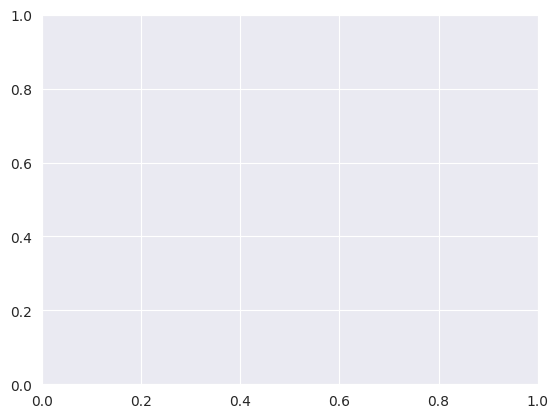

In [121]:
list = []
for i in train:
    if(i[1] == 0):
        list.append("Pneumonia")
    else:
        list.append("Normal")
sns.set_style('darkgrid')
sns.countplot()   

Text(0.5, 1.0, 'NORMAL')

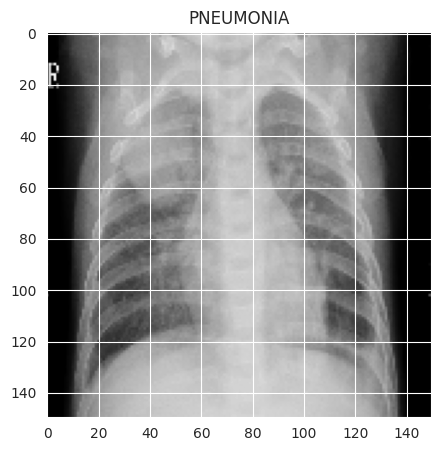

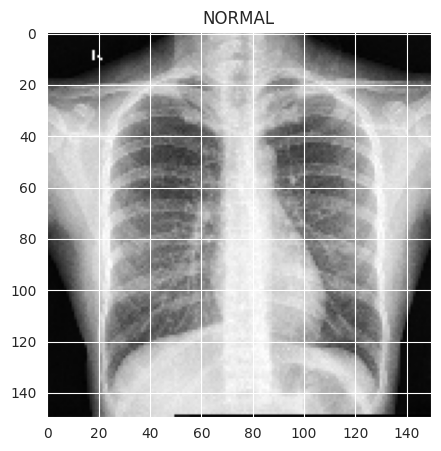

In [122]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [123]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [124]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [125]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,
        zca_whitening=False,  
        rotation_range = 30,  
        zoom_range = 0.2,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip = True,  
        vertical_flip=False)  

datagen.fit(x_train)

## Train

In [126]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_20 (Ba  (None, 150, 150, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_16 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_21 (Ba  (None, 75, 75, 64)       

In [127]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [128]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 15 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/15
9/9 [==============================] - 13s 1s/step - loss: 4.9027 - accuracy: 0.6667 - lr: 0.0010
Epoch 2/15
9/9 [==============================] - 12s 1s/step - loss: 0.3106 - accuracy: 0.8837 - lr: 0.0010
Epoch 3/15
9/9 [==============================] - 14s 2s/step - loss: 0.3790 - accuracy: 0.8721 - lr: 0.0010
Epoch 4/15
9/9 [==============================] - 14s 2s/step - loss: 0.3578 - accuracy: 0.8450 - lr: 0.0010
Epoch 5/15
9/9 [==============================] - 15s 2s/step - loss: 0.5535 - accuracy: 0.7984 - lr: 0.0010
Epoch 6/15
9/9 [==============================] - 14s 2s/step - loss: 0.2520 - accuracy: 0.8798 - lr: 0.0010
Epoch 7/15
9/9 [==============================] - 12s 2s/step - loss: 0.2622 - accuracy: 0.9031 - lr: 0.0010
Epoch 8/15
9/9 [==============================] - 14s 1s/step - loss: 0.4801 - accuracy: 0.8450 - lr: 0.0010
Epoch 9/15
9/9 [==============================] - 14s 2s/step - loss: 0.3706 - accuracy: 0.8682 - lr: 0.0010
Epoch 10/15
9/9 [==

In [129]:
print("Loss : " , model.evaluate(x_test,y_test)[0])
print("Accuracy : " , model.evaluate(x_test,y_test)[1]*100 , "%")

1/1 [==============================] - 0s 291ms/step - loss: 24.7121 - accuracy: 0.5000
Loss of the model is -  24.71210479736328
1/1 [==============================] - 0s 58ms/step - loss: 24.7121 - accuracy: 0.5000
Accuracy of the model is -  50.0 %


## Model değerlendirme

In [130]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history.get('val_accuracy', None)
val_loss = history.history.get('val_loss', None)

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)


train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history.get('val_accuracy', None)
val_loss = history.history.get('val_loss', None)

fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy') if val_acc is not None else None
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss') if val_loss is not None else None
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")

plt.show()


In [132]:
predictions_probs = model.predict(x_test)
predictions = np.argmax(predictions_probs, axis=1)
predictions


1/1 [==============================] - 0s 202ms/step


array([0, 0, 0, 0])

In [ ]:
model.save("model.h5")